In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop

train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

print("train/validation: ",train_dir)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

print("test: ",test_dir)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

train:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\images - Copy (2)\train
Found 271 files belonging to 2 classes.
validation:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\images - Copy (2)\validation
Found 96 files belonging to 2 classes.


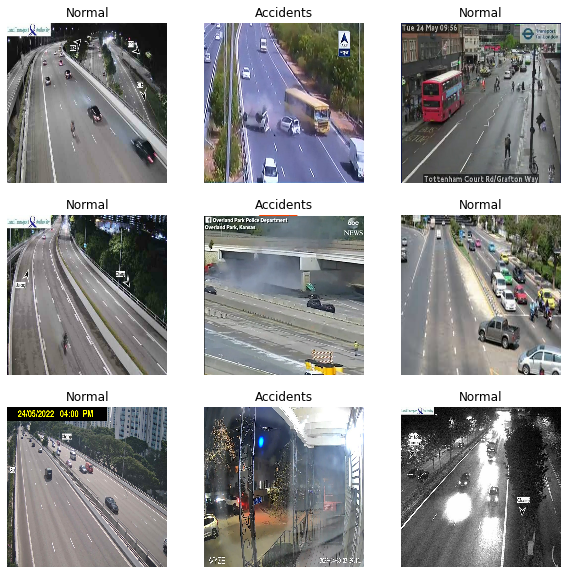

In [2]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Move 20% of validation set to test set (In this case 1 since only 3 batches)

In [3]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [4]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


Configure the Dataset For Performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

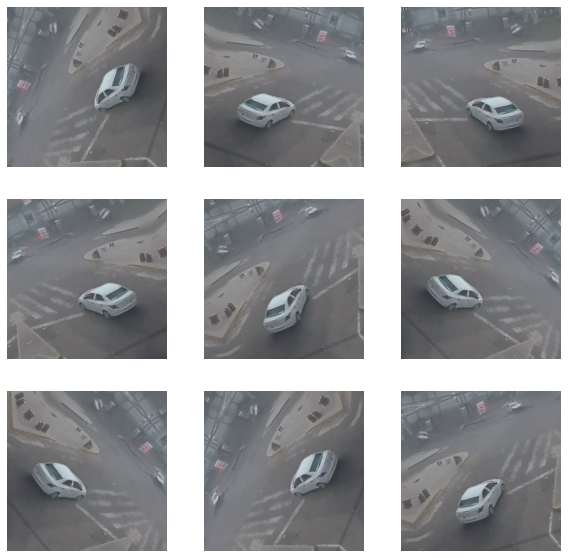

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling Pixel Values

In [7]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Creating Base Model from VGG16

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG16(weights="imagenet", 
                   include_top=False, 
                   input_shape=IMG_SHAPE)

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 512)


# Feature Extraction

In [9]:
### Freeze The Convolutional Base
#It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from 
#being updated during training. MobileNet V2 has many layers, so setting the entire model's 
#trainable flag to False will freeze all of them.

base_model.trainable = False

In [10]:
### Important note about BatchNormalization layers

#Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions 
#should be taken in the context of fine-tuning, as shown later in this tutorial. 

#When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will 
#not update its mean and variance statistics. 

#When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep 
#the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. 
#Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

#For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [11]:
### Add a classification head

#To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [12]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='sigmoid')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [13]:
### Compile the model
model.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

#The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. 
#These are divided between two `tf.Variable` objects, the weights and biases.

len(model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 50)                640050    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,355,863
Trainable params: 641,175
Non-trainable params: 14,714,688
_________________________________________________________________


6

In [14]:
### Train the model

#After training for 10 epochs, you should see ~94% accuracy on the validation set.


initial_epochs = 10

#loss0, accuracy0 = model.evaluate(validation_dataset)

#print("initial loss: {:.2f}".format(loss0))
#print("initial accuracy: {:.2f}".format(accuracy0))

#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)


Epoch 1/10
9/9 [==============================] - 41s 5s/step - loss: 3.2106 - accuracy: 0.5683 - val_loss: 0.4701 - val_accuracy: 0.8594
Epoch 2/10
9/9 [==============================] - 43s 5s/step - loss: 0.2701 - accuracy: 0.9336 - val_loss: 0.3869 - val_accuracy: 0.8906
Epoch 3/10
9/9 [==============================] - 47s 5s/step - loss: 0.0659 - accuracy: 0.9815 - val_loss: 0.4010 - val_accuracy: 0.9062
Epoch 4/10
9/9 [==============================] - 44s 5s/step - loss: 0.0184 - accuracy: 0.9963 - val_loss: 0.2205 - val_accuracy: 0.9375
Epoch 5/10
9/9 [==============================] - 45s 5s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.3032 - val_accuracy: 0.9219
Epoch 6/10
9/9 [==============================] - 45s 5s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2770 - val_accuracy: 0.9219
Epoch 7/10
9/9 [==============================] - 41s 5s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2595 - val_accuracy: 0.9375
Epoch 8/10
9/9 [==================

In [15]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))


2/2 [==============================] - 8s 4s/step - loss: 0.1935 - accuracy: 0.9531
loss: 0.19
accuracy: 0.95


# Fine tuning

In [18]:
#In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. 
#The weights of the pre-trained network were **not** updated during training.

#One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the 
#pre-trained model alongside the training of the classifier you added. The training process will force the weights 
#to be tuned from generic feature maps to features associated specifically with the dataset.

#Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set 
#to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train 
#all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) 
#and your pre-trained model will forget what it has learned.

#Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional 
#networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features 
#that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset 
#on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, 
#rather than overwrite the generic learning.

### Un-freeze the top layers of the model


#All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the 
#model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  19


In [20]:

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
### Compile the model

#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower 
#learning rate at this stage. Otherwise, your model could overfit very quickly.

model.compile(optimizer= RMSprop(learning_rate=0.0001/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 50)                640050    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,355,863
Trainable params: 7,720,599
Non-trainable params: 7,635,264
_________________________________________________________________


12

In [22]:
### Continue training the model

#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)



Epoch 10/20
9/9 [==============================] - 44s 5s/step - loss: 4.5359e-04 - accuracy: 1.0000 - val_loss: 0.2606 - val_accuracy: 0.9375
Epoch 11/20
9/9 [==============================] - 49s 6s/step - loss: 6.4838e-04 - accuracy: 1.0000 - val_loss: 0.2283 - val_accuracy: 0.9531
Epoch 12/20
9/9 [==============================] - 47s 5s/step - loss: 1.9823e-05 - accuracy: 1.0000 - val_loss: 0.3249 - val_accuracy: 0.9375
Epoch 13/20
9/9 [==============================] - 47s 5s/step - loss: 1.1846e-05 - accuracy: 1.0000 - val_loss: 0.2760 - val_accuracy: 0.9375
Epoch 14/20
9/9 [==============================] - 48s 5s/step - loss: 8.8782e-06 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 0.9531
Epoch 15/20
9/9 [==============================] - 48s 5s/step - loss: 6.3090e-06 - accuracy: 1.0000 - val_loss: 0.2947 - val_accuracy: 0.9219
Epoch 16/20
9/9 [==============================] - 47s 5s/step - loss: 4.4165e-06 - accuracy: 1.0000 - val_loss: 0.1463 - val_accuracy: 0.9531

In [23]:
loss1, accuracy1 = model.evaluate(validation_dataset)

print("loss: {:.2f}".format(loss1))
print("accuracy: {:.2f}".format(accuracy1))


2/2 [==============================] - 8s 4s/step - loss: 0.2505 - accuracy: 0.9219
loss: 0.25
accuracy: 0.92


In [24]:
#Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few 
#layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the 
#training loss, so you may get some overfitting.

#You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


#After fine tuning the model nearly reaches 98% accuracy on the validation set.

acc = history.history['accuracy']
acc += history_fine.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']

val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']



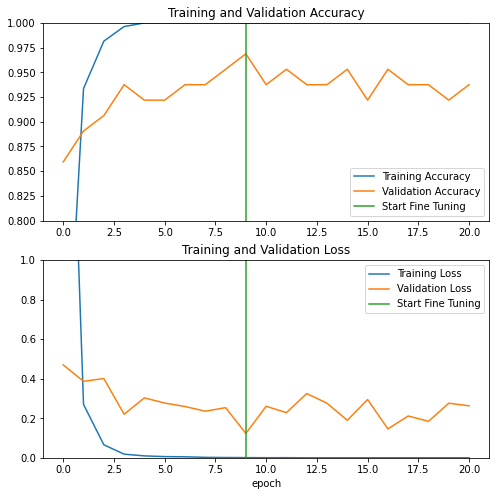

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
### Evaluation and prediction

#Finally you can verify the performance of the model on new data using test set.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.2900 - accuracy: 0.9375
Test accuracy : 0.9375


In [1]:
#And now you are all set to use this model to predict if your pet is a normal or accident.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

NameError: name 'test_dataset' is not defined